In [8]:
%pip install pandas
%pip install duckdb
%pip install notebook

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Creating Datasets and Inserting Data

In [9]:
import duckdb
import pandas as pd

# Connection to DuckDB database
con = duckdb.connect('my_database.duckdb')

# Base folder for all CSVs
csv_folder = './Dataset_problem/'

# app_events
con.execute(f"""
CREATE TABLE IF NOT EXISTS app_events AS
SELECT *
FROM read_csv_auto('{csv_folder}app_events.csv')
""")

# users
con.execute(f"""
CREATE TABLE IF NOT EXISTS users AS
SELECT *
FROM read_csv_auto('{csv_folder}users.csv')
""")

# activity_data
con.execute(f"""
CREATE TABLE IF NOT EXISTS activity_data AS
SELECT *
FROM read_csv_auto('{csv_folder}activity_data.csv')
""")

# app_sessions
con.execute(f"""
CREATE TABLE IF NOT EXISTS app_sessions AS
SELECT *
FROM read_csv_auto('{csv_folder}app_sessions.csv')
""")

# daily_scores
con.execute(f"""
CREATE TABLE IF NOT EXISTS daily_scores AS
SELECT *
FROM read_csv_auto('{csv_folder}daily_scores.csv')
""")

# hrv_data
con.execute(f"""
CREATE TABLE IF NOT EXISTS hrv_data AS
SELECT *
FROM read_csv_auto('{csv_folder}hrv_data.csv')
""")

# journal_entries
con.execute(f"""
CREATE TABLE IF NOT EXISTS journal_entries AS
SELECT *
FROM read_csv_auto('{csv_folder}journal_entries.csv')
""")

# sleep_data
con.execute(f"""
CREATE TABLE IF NOT EXISTS sleep_data AS
SELECT *
FROM read_csv_auto('{csv_folder}sleep_data.csv')
""")

# subscriptions
con.execute(f"""
CREATE TABLE IF NOT EXISTS subscriptions AS
SELECT *
FROM read_csv_auto('{csv_folder}subscriptions.csv')
""")

# team_memberships
con.execute(f"""
CREATE TABLE IF NOT EXISTS team_memberships AS
SELECT *
FROM read_csv_auto('{csv_folder}team_memberships.csv')
""")

# teams
con.execute(f"""
CREATE TABLE IF NOT EXISTS teams AS
SELECT *
FROM read_csv_auto('{csv_folder}teams.csv')
""")


### User Cohort
For this analysis, we are using the last 4 months of data, where the cohort consists of users who joined between 90–120 days before the latest record. This helps us analyze user engagement and retention patterns from Day 1 to Day 90.

### App Retention

### Snapshot / union
The query filters users based on their signup date within the selected cohort, then tracks their engagement through both app sessions (lasting more than 30 seconds) and manually recorded activities. It merges these two data sources to create a unified retention dataset and finally calculates distinct user retention rates across different time intervals — D1, D7, D15, D30, D60, and D90 — to understand how consistently users continue interacting with the app over time.

In [10]:
absolute_retention = con.execute("""
-- users from last third month of the latest record
WITH filtered_users AS (
    SELECT
        user_id,
        created_at::DATE AS signup_date
    FROM users
    WHERE CAST(created_at AS DATE)
          BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
              AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
),

-- App sessions (30+ seconds)
app_sessions_base AS (
    SELECT DISTINCT
        fu.user_id,
        CAST(ap.session_start AS DATE) - fu.signup_date AS retention_date
    FROM filtered_users fu
    JOIN app_sessions ap 
        ON fu.user_id = ap.user_id
    WHERE ap.session_duration_seconds > 30
),

-- Activity data (any activity recorded by user)
activity_base AS (
    SELECT DISTINCT
        fu.user_id,
        CAST(ad.activity_start AS DATE) - fu.signup_date AS retention_date
    FROM filtered_users fu
    JOIN activity_data ad 
        ON fu.user_id = ad.user_id
        and ad.detected_automatically = FALSE
),

-- Combine both sources into one unified retention dataset
combined_retention AS (
    SELECT user_id, retention_date FROM app_sessions_base
    UNION
    SELECT user_id, retention_date FROM activity_base
)

-- Final retention counts
SELECT
    COUNT(DISTINCT user_id) AS total_retend_users,
    COUNT(DISTINCT CASE WHEN retention_date = 1 THEN user_id END) AS D1_retention,
    COUNT(DISTINCT CASE WHEN retention_date = 7 THEN user_id END) AS D7_retention,
    COUNT(DISTINCT CASE WHEN retention_date = 15 THEN user_id END) AS D15_retention,
    COUNT(DISTINCT CASE WHEN retention_date = 30 THEN user_id END) AS D30_retention,
    COUNT(DISTINCT CASE WHEN retention_date = 60 THEN user_id END) AS D60_retention,
    COUNT(DISTINCT CASE WHEN retention_date = 90 THEN user_id END) AS D90_retention
FROM combined_retention;
""").fetchdf()
absolute_retention

,total_retend_users,D1_retention,D7_retention,D15_retention,D30_retention,D60_retention,D90_retention
0,1117,209,236,226,232,234,229


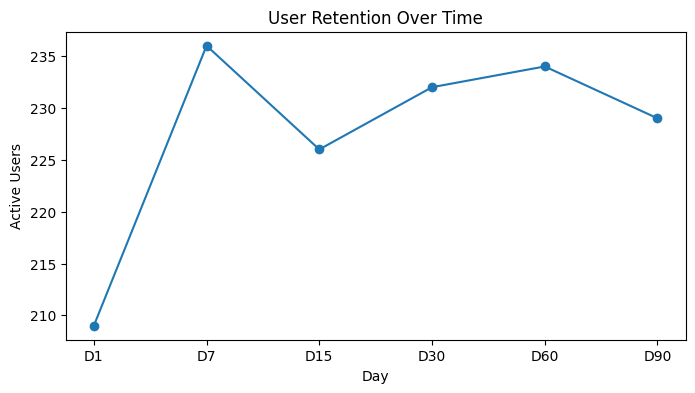

In [11]:
import matplotlib.pyplot as plt

days = ["D1", "D7", "D15", "D30", "D60", "D90"]
values = [
    absolute_retention["D1_retention"][0],
    absolute_retention["D7_retention"][0],
    absolute_retention["D15_retention"][0],
    absolute_retention["D30_retention"][0],
    absolute_retention["D60_retention"][0],
    absolute_retention["D90_retention"][0],
]

plt.figure(figsize=(8, 4))
plt.plot(days, values, marker="o")
plt.title("User Retention Over Time")
plt.xlabel("Day")
plt.ylabel("Active Users")
plt.show()


### Checkpoint funnel

This query first filters users who signed up between 90–120 days before the latest record, then combines their app sessions (over 30 seconds) and manually detected activities into a single activity dataset. Using this, it calculates how many users stayed active at each retention checkpoint — first day, seventh day, thirtieth day, and ninetieth day — showing how user engagement drops or sustains across the lifecycle.

In [12]:
retention_funnel = con.execute("""
-- users from last third month of the latest record
    WITH filtered_users AS (
    SELECT
        user_id,
        created_at::DATE AS signup_date
    FROM users
    WHERE CAST(created_at AS DATE)
          BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
              AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
),

-- Combined app_sessions (>30 sec) and activity_data into one activity base
activity_base AS (
    SELECT DISTINCT
        fu.user_id,
        CAST(ap.session_start AS DATE) - fu.signup_date AS retention_date
    FROM filtered_users fu
    JOIN app_sessions ap ON fu.user_id = ap.user_id
    WHERE ap.session_duration_seconds > 30

    UNION ALL

    SELECT DISTINCT
        fu.user_id,
        CAST(ad.activity_start AS DATE) - fu.signup_date AS retention_date
    FROM filtered_users fu
    JOIN activity_data ad ON fu.user_id = ad.user_id
    and ad.detected_automatically = FALSE
),

-- D1 Retention (Active either via app_session >30s or activity)
d1_retention AS (
    SELECT DISTINCT user_id
    FROM activity_base
    WHERE retention_date = 1
),

-- D7 Retention (must be active on both D1 and D7)
d7_retention AS (
    SELECT DISTINCT r.user_id
    FROM d1_retention r
    JOIN activity_base ab ON r.user_id = ab.user_id AND ab.retention_date = 7
),

-- D30 Retention (active on D1, D7, and D30)
d30_retention AS (
    SELECT DISTINCT r.user_id
    FROM d7_retention r
    JOIN activity_base ab ON r.user_id = ab.user_id AND ab.retention_date = 30
),

-- D90 Retention (active on D1, D7, D30, and D90)
d90_retention AS (
    SELECT DISTINCT r.user_id
    FROM d30_retention r
    JOIN activity_base ab ON r.user_id = ab.user_id AND ab.retention_date = 90
)

-- Final Aggregation
SELECT
  (SELECT COUNT(DISTINCT user_id) FROM filtered_users) AS total_sign_up_users,
  (SELECT COUNT(*) FROM d1_retention) AS d1_retention,
  (SELECT COUNT(*) FROM d7_retention) AS d7_retention,
  (SELECT COUNT(*) FROM d30_retention) AS d30_retention,
  (SELECT COUNT(*) FROM d90_retention) AS d90_retention;

""").fetchdf()
retention_funnel

,total_sign_up_users,d1_retention,d7_retention,d30_retention,d90_retention
0,1250,209,68,26,14


### Feature Popularity

This query first filters cohort users and tracks how often each feature (excluding core and profile actions like app opens or profile views) is accessed. Then, it groups users based on how many distinct days they interacted with each feature — 1 day, 2–7 days, 8–15 days, or more than 15 days. Finally, it aggregates and ranks features by total users who engaged with them, helping identify which app features are most and least adopted over time.

In [13]:
feature_popularity = con.execute(
"""
    -- users from last third month of the latest record
    WITH filtered_users AS (
      SELECT user_id, CAST(created_at AS DATE) AS signup_date
      FROM users
      WHERE CAST(created_at AS DATE)
        BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
            AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
    ),

    -- filtering app events on cohort users.
    events_clean AS (
      SELECT
        ae.user_id,
        ae.feature_category,
        count(distinct cast(ae.event_time as date))as feature_accessed_days
      FROM app_events ae
      JOIN filtered_users fu ON ae.user_id = fu.user_id and cast(event_time as date) > signup_date
      where feature_category not in ('core','profile')  -- removing app_open, app_close and profile clicks
      group by 1,2
      order by 1
    ),

    -- ditributing events on number of it is being accessed by each user.
    buckets AS (
      SELECT
        feature_category,
        user_id,
        feature_accessed_days,
        CASE
          WHEN feature_accessed_days = 1 THEN '1'
          WHEN feature_accessed_days BETWEEN 2 AND 7 THEN '2_7'
          WHEN feature_accessed_days BETWEEN 8 AND 15 THEN '8_15'
          WHEN feature_accessed_days > 15 THEN 'gt_15'
          ELSE '0'
        END AS bucket
      FROM events_clean
    )

    -- aggregating the count of users based on the bucket
    select 
    feature_category,
    count(distinct user_id) as users_accessed_feature,
    count(case when bucket = '1' then user_id end) as days_interacted_1,
    count(case when bucket = '2_7' then user_id end) as days_interacted_2_7,
    count(case when bucket = '8_15' then user_id end) as days_interacted_8_15,
    count(case when bucket = 'gt_15' then user_id end) as days_interacted_gt_15
    from buckets
    group by 1
    order by 2 desc

"""
).fetchdf()
feature_popularity

,feature_category,users_accessed_feature,days_interacted_1,days_interacted_2_7,days_interacted_8_15,days_interacted_gt_15
0,strain,781,23,167,258,333
1,sleep,778,26,166,255,331
2,journal,770,35,253,301,181
3,recovery,763,38,244,293,188
4,reports,763,42,273,297,151
5,teams,751,54,304,292,101
6,coaching,734,76,423,198,37


### Conversion funnel from free users to premium subscribers
This query analyzes conversion behavior from free to paid users using subscription and signup data.

The query filters users who joined between 90–120 days before the latest record and joins them with subscription details to identify users who canceled within 31 days — assumed to be free trial users (since the dataset doesn’t explicitly mention free or premium tiers).

The query then:

Counts total subscribed users, continued users, and canceled users (within 31 days).

Calculates conversion rate (users continuing post-trial) and cancellation rate (users churning during trial).

Note: The 1-month free trial assumption is made due to the absence of explicit classification in the dataset.

In [14]:
free_user_data = con.execute(
    """
        -- users from last third month of the latest record
       WITH filtered_users AS (
            SELECT
                u.user_id,
                u.created_at::DATE AS signup_date,
                TRY_CAST(s.cancellation_date AS TIMESTAMP) AS subscription_cancel_date
            FROM users u
            JOIN subscriptions s 
                ON s.user_id = u.user_id
            WHERE CAST(u.created_at AS DATE)
                  BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
                      AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
        ),
        
        -- Count of total users subscribed, users who continued subscription,
        -- and users who cancelled within 31 days (free trial churn)
        conversion_base as (
        SELECT
            COUNT(user_id) AS total_users_subscribed,
            COUNT(user_id) - COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                        AND (subscription_cancel_date::DATE - signup_date) < 31 
                   THEN user_id END) AS user_continued_subscription,
            COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                        AND (subscription_cancel_date::DATE - signup_date) < 31 
                   THEN user_id END) AS cancelled_free_user
        FROM filtered_users
        )

        -- conversion and cancellation rates as percentages
        SELECT 
            *,
            (user_continued_subscription * 1.00 / total_users_subscribed) * 100 AS conversion_rate,
            (cancelled_free_user * 1.00 / total_users_subscribed) * 100 AS cancellation_rate
        FROM conversion_base;
    """
).fetchdf()
free_user_data

,total_users_subscribed,user_continued_subscription,cancelled_free_user,conversion_rate,cancellation_rate
0,1250,768,482,61.44,38.56


### Cancellation Funnel on Plan Type

This query analyzes cancellation behavior segmented by subscription plan type.

For each plan type, it calculates:

1. Total subscribers.
2. Users who canceled within 30 days of signup (indicating early churn, likely within the trial period).
3. Cancellation rate (%), showing the proportion of users who churned early for each plan.

In [15]:
cancellation_rate_plan_based = con.execute(    """
        -- users from last third month of the latest record
        WITH filtered_users AS (
            SELECT
                u.user_id,
                u.created_at::DATE AS signup_date,
                s.plan_type,
                TRY_CAST(s.cancellation_date AS TIMESTAMP) AS subscription_cancel_date
            FROM users u
            JOIN subscriptions s 
                ON s.user_id = u.user_id
            WHERE CAST(u.created_at AS DATE)
                  BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
                      AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
        )
        
        SELECT
            plan_type,
            COUNT(user_id) AS total_subscribers,
            COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                        AND (subscription_cancel_date::DATE - signup_date) < 31 
                   THEN 1 END) AS cancelled_within_30d,
            ROUND(100.0 * COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                        AND (subscription_cancel_date::DATE - signup_date) < 31 THEN 1 END)
                  / COUNT(user_id), 2) AS cancellation_rate_pct
        FROM filtered_users
        GROUP BY plan_type
        ORDER BY cancellation_rate_pct DESC;
    """
).fetchdf()
cancellation_rate_plan_based

,plan_type,total_subscribers,cancelled_within_30d,cancellation_rate_pct
0,monthly,779,322,41.34
1,annual,353,122,34.56
2,biannual,118,38,32.20


### Cancellation Rate on Payment Method

In [16]:
cancellation_rate_payment_based = con.execute(
    """
        WITH filtered_users AS (
            SELECT
                u.user_id,
                u.created_at::DATE AS signup_date,
                s.payment_method,
                TRY_CAST(s.cancellation_date AS TIMESTAMP) AS subscription_cancel_date
            FROM users u
            JOIN subscriptions s 
                ON s.user_id = u.user_id
            WHERE CAST(u.created_at AS DATE)
                  BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
                      AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
        )
    SELECT
        payment_method,
        COUNT(user_id) AS total_subscribers,
        COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                    AND (subscription_cancel_date::DATE - signup_date) < 31 THEN 1 END) AS cancelled_within_30d,
        ROUND(100.0 * COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                    AND (subscription_cancel_date::DATE - signup_date) < 31 THEN 1 END)
              / COUNT(user_id), 2) AS cancellation_rate_pct
    FROM filtered_users f
    GROUP BY payment_method
    ORDER BY cancellation_rate_pct DESC;
    """
).fetchdf()
cancellation_rate_payment_based

,payment_method,total_subscribers,cancelled_within_30d,cancellation_rate_pct
0,google_pay,172,68,39.53
1,apple_pay,425,168,39.53
2,paypal,240,94,39.17
3,credit_card,413,152,36.80


### Cancellation Rate by Reason of Cancellation

In [17]:
cancellation_reason = con.execute(
    """
        WITH filtered_users AS (
            SELECT
                u.user_id,
                u.created_at::DATE AS signup_date,
                s.cancellation_reason,
                TRY_CAST(s.cancellation_date AS TIMESTAMP) AS subscription_cancel_date
            FROM users u
            JOIN subscriptions s 
                ON s.user_id = u.user_id
            WHERE CAST(u.created_at AS DATE)
                  BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
                      AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
        )
        SELECT
            cancellation_reason,
            COUNT(user_id) AS users_cancelled,
            COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                    AND (subscription_cancel_date::DATE - signup_date) < 31 THEN 1 END) AS cancelled_within_30d,
        ROUND(100.0 * COUNT(CASE WHEN subscription_cancel_date IS NOT NULL 
                    AND (subscription_cancel_date::DATE - signup_date) < 31 THEN 1 END)
              / COUNT(user_id), 2) AS cancellation_rate_pct
        FROM filtered_users f
        GROUP BY cancellation_reason
        ORDER BY cancellation_rate_pct DESC;
    """
).fetchdf()
cancellation_reason

,cancellation_reason,users_cancelled,cancelled_within_30d,cancellation_rate_pct
0,technical_issues,53,45,84.91
1,customer_service,59,46,77.97
2,privacy_concerns,71,55,77.46
3,found_better_app,93,72,77.42
4,poor_battery_life,82,61,74.39
5,device_uncomfortable,68,50,73.53
6,too_expensive,83,60,72.29
7,didnt_use_enough,71,50,70.42
8,didnt_like_interface,63,43,68.25
9,None,607,0,0.00


### Finding Anamoly

During the app retention analysis, an anomaly was identified:
Even after canceling their subscriptions, some users were still able to access and interact with the app.

This query checks for users who canceled within 30 days of signup but continued generating app events post-cancellation.

The results show:
1. Total users who canceled within 30 days.
2. How many of them remained active afterward.
3. The percentage of users still active post-cancellation.

In [18]:
users_able_to_access_after_cancellation = con.execute(
    """
        WITH filtered_users AS (
            SELECT
                u.user_id,
                CAST(u.created_at AS DATE) AS signup_date,
                TRY_CAST(s.cancellation_date AS TIMESTAMP) AS subscription_cancel_date
            FROM users u
            LEFT JOIN subscriptions s 
                ON s.user_id = u.user_id
            WHERE CAST(u.created_at AS DATE)
                  BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
                      AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
        ),

        cancelled_within_30_days AS (
            SELECT
                user_id,
                signup_date,
                subscription_cancel_date
            FROM filtered_users
            WHERE subscription_cancel_date IS NOT NULL
              AND (subscription_cancel_date::DATE - signup_date) < 31
        ),

        activity_base AS (
            SELECT DISTINCT
                c.user_id,
                CASE 
                    WHEN COUNT(ae.event_id) OVER (PARTITION BY c.user_id) > 0 
                    THEN c.user_id 
                    ELSE NULL 
                END AS active_after_cancellation
            FROM cancelled_within_30_days c
            LEFT JOIN app_events ae 
                ON c.user_id = ae.user_id
               AND ae.event_time > c.subscription_cancel_date
        )

        SELECT 
            COUNT(DISTINCT user_id) AS total_cancelled_within_30_days,
            COUNT(DISTINCT active_after_cancellation) AS users_active_after_cancellation,
            ROUND(100.0 * COUNT(DISTINCT active_after_cancellation) / 
                         NULLIF(COUNT(DISTINCT user_id), 0), 2) AS pct_active_after_cancellation
        FROM activity_base;
    """
).fetchdf()

users_able_to_access_after_cancellation


,total_cancelled_within_30_days,users_active_after_cancellation,pct_active_after_cancellation
0,482,297,61.62


### Onboarding Funnel

This query analyzes the user onboarding journey by tracking how users progress after signing up.
It evaluates key steps such as calibration completion, notification opt-in, first app session, and first activity.
Additionally, it computes engagement rates, average and median time to first interaction, and overall user activation efficiency — helping identify drop-offs in early user experience.

In [19]:
# Onboarding funnel

onboarding_funnel = con.execute(
    """
        WITH filtered_users AS (
            SELECT
                user_id,
                created_at::DATE AS signup_date,
                calibration_complete,
                notification_enabled
            FROM users
            WHERE CAST(created_at AS DATE)
                  BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
                      AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
        ),

        first_session AS (
            SELECT
                user_id,
                MIN(CAST(session_start AS DATE)) AS first_session_date,
                MIN(session_start) - MIN(session_start) AS temp -- placeholder to ensure single row per user
            FROM app_sessions
            GROUP BY user_id
        ),

        first_activity AS (
            SELECT
                user_id,
                MIN(CAST(activity_start AS DATE)) AS first_activity_date,
                COUNT(*) AS total_activities,
                COUNT(CASE WHEN detected_automatically = FALSE THEN 1 END) AS manual_activities
            FROM activity_data
            GROUP BY user_id
        ),

        combined AS (
            SELECT
                fu.user_id,
                fu.signup_date,
                fu.calibration_complete,
                fu.notification_enabled,
                fs.first_session_date,
                fa.first_activity_date,
                fs.first_session_date - fu.signup_date AS days_to_first_session,
                fa.first_activity_date - fu.signup_date AS days_to_first_activity,
                fa.manual_activities
            FROM filtered_users fu
            LEFT JOIN first_session fs ON fu.user_id = fs.user_id
            LEFT JOIN first_activity fa ON fu.user_id = fa.user_id
        )

        SELECT
            COUNT(DISTINCT user_id) AS total_signed_up,
            COUNT(DISTINCT CASE WHEN calibration_complete = TRUE THEN user_id END) AS calibrated_users,
            COUNT(DISTINCT CASE WHEN first_session_date IS NOT NULL THEN user_id END) AS users_with_first_session,
            COUNT(DISTINCT CASE WHEN first_activity_date IS NOT NULL THEN user_id END) AS users_with_first_activity,
            COUNT(DISTINCT CASE WHEN notification_enabled = TRUE THEN user_id END) AS users_with_notifications_enabled,
            COUNT(DISTINCT CASE WHEN manual_activities > 0 THEN user_id END) AS users_with_activity,
        
            ROUND(100.0 * COUNT(DISTINCT CASE WHEN calibration_complete = TRUE THEN user_id END) / COUNT(DISTINCT user_id), 2) AS calibration_completion_rate,
            ROUND(100.0 * COUNT(DISTINCT CASE WHEN first_session_date IS NOT NULL THEN user_id END) / COUNT(DISTINCT user_id), 2) AS app_interaction_rate,
            ROUND(100.0 * COUNT(DISTINCT CASE WHEN manual_activities > 0 THEN user_id END) / COUNT(DISTINCT user_id), 2) AS activity_engagement_rate,
            ROUND(100.0 * COUNT(DISTINCT CASE WHEN notification_enabled = TRUE THEN user_id END) / COUNT(DISTINCT user_id), 2) AS notification_opt_in_rate,
        
            ROUND(AVG(days_to_first_session), 1) AS avg_days_to_first_session,
            ROUND(AVG(days_to_first_activity), 1) AS avg_days_to_first_activity,
            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY days_to_first_session) AS median_days_to_first_session,
            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY days_to_first_activity) AS median_days_to_first_activity
        FROM combined;
    """
).fetchdf()
onboarding_funnel

,total_signed_up,calibrated_users,users_with_first_session,users_with_first_activity,users_with_notifications_enabled,users_with_activity,calibration_completion_rate,app_interaction_rate,activity_engagement_rate,notification_opt_in_rate,avg_days_to_first_session,avg_days_to_first_activity,median_days_to_first_session,median_days_to_first_activity
0,1250,1193,784,1174,1020,895,95.44,62.72,71.6,81.6,4.8,11.4,2.0,5.0


### Analysing first session funnel drop

This query compares user activation across different platforms (e.g., iOS, Android).
It tracks when users had their first session after signup and calculates activation rates(interaction with app after signup).
Finally, it summarizes metrics like average, median, min, and max days to first session by platform.

In [20]:
funnel_bf_platform = con.execute(
    """
    WITH filtered_users AS (
    SELECT
        user_id,
        CAST(created_at AS DATE) AS signup_date,
        app_platform
    FROM users
    WHERE CAST(created_at AS DATE)
          BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
              AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
),

first_session AS (
    SELECT
        fu.user_id,
        MIN(asess.session_start::DATE) AS first_session_date,
        fu.app_platform
    FROM filtered_users fu
    JOIN app_sessions asess
        ON fu.user_id = asess.user_id
    GROUP BY fu.user_id, fu.app_platform
),

platform_user_counts AS (
    SELECT
        app_platform,
        COUNT(user_id) AS total_signed_up
    FROM filtered_users
    GROUP BY app_platform
),

activation_metrics AS (
    SELECT
        fs.app_platform,
        puc.total_signed_up,
        COUNT(fs.user_id) AS users_with_first_session,
        ROUND(100.0 * COUNT(fs.user_id) / puc.total_signed_up, 2) AS activation_rate,
        ROUND(AVG(first_session_date - signup_date),2) AS avg_days_to_first_session,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY first_session_date - signup_date) AS median_days_to_first_session,
        MIN(first_session_date - signup_date) AS min_days_to_first_session,
        MAX(first_session_date - signup_date) AS max_days_to_first_session
    FROM first_session fs
    JOIN filtered_users fu ON fs.user_id = fu.user_id
    JOIN platform_user_counts puc ON fs.app_platform = puc.app_platform
    GROUP BY 1, 2
)

SELECT * 
FROM activation_metrics
ORDER BY activation_rate DESC;

    """
).fetchdf()
funnel_bf_platform

,app_platform,total_signed_up,users_with_first_session,activation_rate,avg_days_to_first_session,median_days_to_first_session,min_days_to_first_session,max_days_to_first_session
0,Android,436,281,64.45,4.28,2.0,0,55
1,iOS,814,503,61.79,5.15,2.0,0,81


### Analysing funnel drop based on acquisition source
This query analyzes user activation based on acquisition source (e.g., ads, referrals, organic).
It identifies when users from each source had their first session after signup.
Finally, it calculates the interaction rate and time-to-first-session metrics (average, median, min, max) for each source.

In [21]:
funnel_bf_acquisition_source = con.execute(
    """
        WITH filtered_users AS (
    SELECT
        user_id,
        CAST(created_at AS DATE) AS signup_date,
        acquisition_source
    FROM users
    WHERE CAST(created_at AS DATE)
          BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
              AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
),

first_session AS (
    SELECT
        fu.user_id,
        MIN(asess.session_start::DATE) AS first_session_date,
        fu.acquisition_source
    FROM filtered_users fu
    JOIN app_sessions asess
        ON fu.user_id = asess.user_id
    GROUP BY fu.user_id, fu.acquisition_source
),

source_user_counts AS (
    SELECT
        acquisition_source,
        COUNT(user_id) AS total_signed_up
    FROM filtered_users
    GROUP BY acquisition_source
),

activation_metrics AS (
    SELECT
        fs.acquisition_source,
        suc.total_signed_up,
        COUNT(fs.user_id) AS users_with_first_session,
        ROUND(100.0 * COUNT(fs.user_id) / suc.total_signed_up, 2) AS user_interaction_rate,
        ROUND(AVG(first_session_date - signup_date),2) AS avg_days_to_first_session,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY first_session_date - signup_date) AS median_days_to_first_session,
        MIN(first_session_date - signup_date) AS min_days_to_first_session,
        MAX(first_session_date - signup_date) AS max_days_to_first_session
    FROM first_session fs
    JOIN filtered_users fu ON fs.user_id = fu.user_id
    JOIN source_user_counts suc ON fs.acquisition_source = suc.acquisition_source
    GROUP BY fs.acquisition_source, suc.total_signed_up
)

SELECT * 
FROM activation_metrics
ORDER BY user_interaction_rate DESC;

    """
).fetchdf()
funnel_bf_acquisition_source

,acquisition_source,total_signed_up,users_with_first_session,user_interaction_rate,avg_days_to_first_session,median_days_to_first_session,min_days_to_first_session,max_days_to_first_session
0,Instagram Ad,166,110,66.27,5.26,2.5,0,56
1,Referral,177,117,66.10,4.91,2.0,0,74
2,Organic Search,187,122,65.24,3.95,1.5,0,63
3,YouTube Ad,173,107,61.85,4.40,2.0,0,81
4,Facebook Ad,176,107,60.80,5.54,2.0,0,58
5,Podcast Sponsor,186,113,60.75,5.48,3.0,0,55
6,Direct Website,185,108,58.38,4.41,2.0,0,40


### Analysing funnel drop for age group
This query evaluates user activation by age group to understand engagement differences across demographics.
It tracks when users from each age group had their first session after signup.
Finally, it calculates each group’s interaction rate and time-to-first-session metrics (average, median, min, max).

In [22]:
funnel_bf_age_group = con.execute(
    """
        WITH filtered_users AS (
    SELECT
        user_id,
        CAST(created_at AS DATE) AS signup_date,
        age_group
    FROM users
    WHERE CAST(created_at AS DATE)
          BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
              AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
),

first_session AS (
    SELECT
        fu.user_id,
        MIN(asess.session_start::DATE) AS first_session_date,
        fu.age_group
    FROM filtered_users fu
    JOIN app_sessions asess
        ON fu.user_id = asess.user_id
    GROUP BY fu.user_id, fu.age_group
),

age_group_counts AS (
    SELECT
        age_group,
        COUNT(user_id) AS total_signed_up
    FROM filtered_users
    GROUP BY age_group
),

activation_metrics AS (
    SELECT
        fs.age_group,
        agc.total_signed_up,
        COUNT(fs.user_id) AS users_with_first_session,
        ROUND(100.0 * COUNT(fs.user_id) / agc.total_signed_up, 2) AS user_interaction_rate,
        ROUND(AVG(first_session_date - signup_date),2) AS avg_days_to_first_session,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY first_session_date - signup_date) AS median_days_to_first_session,
        MIN(first_session_date - signup_date) AS min_days_to_first_session,
        MAX(first_session_date - signup_date) AS max_days_to_first_session
    FROM first_session fs
    JOIN filtered_users fu ON fs.user_id = fu.user_id
    JOIN age_group_counts agc ON fs.age_group = agc.age_group
    GROUP BY 1,2
)

SELECT *
FROM activation_metrics
ORDER BY user_interaction_rate DESC;
    """
).fetchdf()
funnel_bf_age_group

,age_group,total_signed_up,users_with_first_session,user_interaction_rate,avg_days_to_first_session,median_days_to_first_session,min_days_to_first_session,max_days_to_first_session
0,35-44,291,189,64.95,5.38,2.0,0,81
1,55-64,90,58,64.44,5.34,2.0,0,42
2,25-34,447,284,63.53,5.15,2.0,0,58
3,18-24,204,129,63.24,4.46,2.0,0,74
4,45-54,194,111,57.22,3.49,2.0,0,28
5,65+,24,13,54.17,3.23,1.0,0,19


### Onboarding Funnel Analysis ^
The data shows that notifications are enabled for over 80% of users. Additionally, there is no clear pattern in interaction rates across acquisition sources, age groups, or platforms. This indicates that the drop-off is not due to user segmentation but is likely caused by genuine challenges faced after signup, which significantly reduce the app interaction funnel and overall conversion.

### Analysing the Behaviour pattern of the churned vs retained users(user retention)

### General behaviour/metric
Assumptions:
1. Users who canceled within 30 days are labeled as "churned," others as "retained."
2. Analysis is limited to the first month post-signup to capture early engagement patterns. This ensures a fair comparison, as churned users are only present for ~30 days, so retained users are also analyzed for the same period.

Description:
This query evaluates user behavior within the first 30 days of signup, combining app events, manual activity recordings, and session data.
It calculates metrics like days interacted, days with recorded activities, average and median session durations, and session intervals.
Additionally, it examines notification opt-in rates and aggregates these metrics by user status (retained vs. churned) to identify behavioral differences that influence retention.

In [23]:
behaviour_pattern = con.execute(
"""
WITH filtered_users AS (
  SELECT
    u.user_id,
    CAST(u.created_at AS DATE) AS signup_date,
    u.notification_enabled,
    TRY_CAST(s.cancellation_date AS DATE) AS subscription_cancel_date
  FROM users u
  LEFT JOIN subscriptions s ON s.user_id = u.user_id
  WHERE CAST(u.created_at AS DATE)
    BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
        AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
),

-- user engagement:
-- Number of distinct days interacted and recorded manual activities within 30 days of signup
user_activity AS (
  SELECT
    fu.user_id,
    COUNT(DISTINCT CAST(ae.event_time AS DATE)) AS days_interacted,
    COUNT(DISTINCT CAST(act.activity_start AS DATE)) AS days_activity_recorded
  FROM filtered_users fu
  LEFT JOIN app_events ae
    ON ae.user_id = fu.user_id
   AND CAST(ae.event_time AS DATE) BETWEEN fu.signup_date AND fu.signup_date + INTERVAL '30' DAY
  LEFT JOIN activity_data act
    ON act.user_id = fu.user_id
   AND CAST(act.activity_start AS DATE) BETWEEN fu.signup_date AND fu.signup_date + INTERVAL '30' DAY
   AND act.detected_automatically = FALSE
  GROUP BY fu.user_id
),

-- per-user session duration stats (sessions inside 30 days)
per_user_session_stats AS (
  SELECT
    s.user_id,
    AVG(s.session_duration_seconds) AS per_user_avg_session_duration,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY s.session_duration_seconds) AS per_user_median_session_duration,
    COUNT(*) AS sessions_count
  FROM app_sessions s
  JOIN filtered_users fu ON s.user_id = fu.user_id
  WHERE CAST(s.session_start AS DATE) BETWEEN fu.signup_date AND fu.signup_date + INTERVAL '30' DAY
  GROUP BY s.user_id
),

-- Calculate time intervals between consecutive sessions for each user
session_intervals_raw AS (
  SELECT
    s.user_id,
    CAST(s.session_start AS TIMESTAMP) AS session_start_ts,
    LEAD(CAST(s.session_start AS TIMESTAMP)) OVER (PARTITION BY s.user_id ORDER BY CAST(s.session_start AS TIMESTAMP)) AS next_session_start_ts
  FROM app_sessions s
  JOIN filtered_users fu ON s.user_id = fu.user_id
  WHERE CAST(s.session_start AS DATE) BETWEEN fu.signup_date AND fu.signup_date + INTERVAL '30' DAY
),

-- Derive per-user average and median session gaps (in days)
per_user_intervals AS (
  SELECT
    user_id,
    AVG(CAST( (CAST(next_session_start_ts AS DATE) - CAST(session_start_ts AS DATE)) AS DOUBLE)) AS avg_interval_days,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY CAST( (CAST(next_session_start_ts AS DATE) - CAST(session_start_ts AS DATE)) AS DOUBLE)) AS median_interval_days,
    COUNT(*) AS interval_count
  FROM session_intervals_raw
  WHERE next_session_start_ts IS NOT NULL
  GROUP BY user_id
),

-- Combine all user-level activity, session, and interval metrics
  -- Keep only users who interacted or recorded activities within 30 days
active_users AS (
  SELECT
    ua.user_id,
    fu.notification_enabled,
    fu.signup_date,
    fu.subscription_cancel_date,
    ua.days_interacted,
    ua.days_activity_recorded,
    pui.avg_interval_days,
    pui.median_interval_days,
    pss.per_user_avg_session_duration,
    pss.per_user_median_session_duration,
    pss.sessions_count
  FROM user_activity ua
  JOIN filtered_users fu ON ua.user_id = fu.user_id
  LEFT JOIN per_user_intervals pui ON ua.user_id = pui.user_id
  LEFT JOIN per_user_session_stats pss ON ua.user_id = pss.user_id
  WHERE (ua.days_interacted > 0 OR ua.days_activity_recorded > 0)
),

-- Label users as "retained" or "churned" based on subscription status within 30 days
labeled_active AS (
  SELECT
    au.*,
    CASE
      WHEN au.subscription_cancel_date IS NOT NULL
           AND (au.subscription_cancel_date - au.signup_date) < 31 THEN 'churned'
      ELSE 'retained'
    END AS user_status
  FROM active_users au
)


SELECT
  user_status,
  COUNT(*) AS total_active_users,
  ROUND(AVG(days_interacted), 2) AS avg_days_interacted,
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY days_interacted), 2) AS median_days_interacted,
  ROUND(AVG(days_activity_recorded), 2) AS avg_days_activity_recorded,
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY days_activity_recorded), 2) AS median_days_activity_recorded,
  ROUND(AVG(avg_interval_days) FILTER (WHERE avg_interval_days IS NOT NULL), 2) AS avg_session_interval_days,
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_interval_days) FILTER (WHERE avg_interval_days IS NOT NULL), 2) AS median_session_interval_days,
  ROUND(AVG(per_user_avg_session_duration) FILTER (WHERE per_user_avg_session_duration IS NOT NULL), 2) AS avg_of_per_user_avg_session_duration_seconds,
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY per_user_avg_session_duration) FILTER (WHERE per_user_avg_session_duration IS NOT NULL), 2) AS median_of_per_user_avg_session_duration_seconds,
  COUNT(CASE WHEN notification_enabled = TRUE THEN 1 END) AS users_with_notifications_enabled,
  ROUND(COUNT(CASE WHEN notification_enabled = TRUE THEN 1 END)/COUNT(*),2) AS notification_enable_rate
FROM labeled_active
GROUP BY user_status
ORDER BY user_status;

"""
).fetchdf()
behaviour_pattern

,user_status,total_active_users,avg_days_interacted,median_days_interacted,avg_days_activity_recorded,median_days_activity_recorded,avg_session_interval_days,median_session_interval_days,avg_of_per_user_avg_session_duration_seconds,median_of_per_user_avg_session_duration_seconds,users_with_notifications_enabled,notification_enable_rate
0,churned,352,4.73,4.0,0.83,0.5,5.29,3.83,170.89,148.60,294,0.84
1,retained,622,7.33,8.0,1.29,1.0,3.17,2.70,211.19,177.85,512,0.82


### Analysing feature behaviour between both the categories
This query summarizes user engagement with app features within the first 30 days after signup.
It calculates metrics like total events, distinct features used, session counts, and session durations and compares them for retained vs churned users to understand which behaviors correlate with user retention.

In [24]:
feature_behaviour_summary = con.execute(
    """
    WITH filtered_users AS (
      SELECT
        u.user_id,
        CAST(u.created_at AS DATE) AS signup_date,
        TRY_CAST(s.cancellation_date AS DATE) AS subscription_cancel_date
      FROM users u
      LEFT JOIN subscriptions s ON s.user_id = u.user_id
      WHERE CAST(u.created_at AS DATE)
        BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
            AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
    ),
    -- per-user session stats (average, median duration, session count) in first 30 days
    per_user_session_stats AS (
      SELECT
        s.user_id,
        AVG(s.session_duration_seconds) AS per_user_avg_session_s,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY s.session_duration_seconds) AS per_user_median_session_s,
        COUNT(*) AS sessions_count
      FROM app_sessions s
      JOIN filtered_users fu ON s.user_id = fu.user_id
      WHERE CAST(s.session_start AS DATE) BETWEEN fu.signup_date AND fu.signup_date + INTERVAL '30' DAY
      GROUP BY s.user_id
    ),

    -- total events and number of distinct non-core features used by each user in first 30 days
    user_feature AS (
      SELECT
        ae.user_id,
        COUNT(*) AS total_events,
        COUNT(DISTINCT ae.feature_category) AS distinct_features_used
      FROM app_events ae
      JOIN filtered_users fu ON ae.user_id = fu.user_id
      WHERE CAST(ae.event_time AS DATE) BETWEEN fu.signup_date AND fu.signup_date + INTERVAL '30' DAY
      and feature_category != 'core'
      GROUP BY ae.user_id
    ),

    -- Combine session stats and feature usage per user
    -- Label users as 'churned' if they cancelled within 30 days, otherwise 'retained'
    user_summary AS (
      SELECT
        fu.user_id,
        fu.signup_date,
        fu.subscription_cancel_date,
        pss.per_user_avg_session_s,
        pss.per_user_median_session_s,
        pss.sessions_count,
        uf.total_events,
        uf.distinct_features_used,
        CASE 
          WHEN fu.subscription_cancel_date IS NOT NULL
               AND (fu.subscription_cancel_date - fu.signup_date) < 31 THEN 'churned'
          ELSE 'retained'
        END AS user_status
      FROM filtered_users fu
      LEFT JOIN per_user_session_stats pss ON fu.user_id = pss.user_id
      LEFT JOIN user_feature uf ON fu.user_id = uf.user_id
    )
    -- Aggregate feature usage and session metrics by user status
    SELECT
      user_status,
      COUNT(DISTINCT user_id) AS total_users,
      ROUND(AVG(total_events),2) AS avg_events_per_user,
      ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_events),2) AS median_events_per_user,
      ROUND(AVG(distinct_features_used),0) AS avg_distinct_features_used,
      ROUND(AVG(sessions_count),2) AS avg_sessions_per_user,
      ROUND(AVG(per_user_avg_session_s),2) AS avg_session_duration,
      ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY per_user_avg_session_s),2) AS median_session_duration
    FROM user_summary
    GROUP BY user_status;
    """
).fetchdf()
feature_behaviour_summary


,user_status,total_users,avg_events_per_user,median_events_per_user,avg_distinct_features_used,avg_sessions_per_user,avg_session_duration,median_session_duration
0,retained,768,39.27,33.0,7.0,10.72,211.19,177.85
1,churned,482,20.87,14.0,6.0,6.57,170.89,148.60


### Session Duration Within 30 days of signup
This query analyzes user session behavior within the first 30 days post-signup, grouped by age_group.

Key points:

1. Users are filtered from the last 4 months cohort.
2. Sessions are bucketed into three periods: days 1–7, 8–15, and 16–30.
3. For each age group and bucket, it calculates:

    a. Number of sessions (session_count)
    b. Median session duration (median_session_duration_seconds)

In [25]:
session_duration = con.execute(
    """
        WITH filtered_users AS (
          SELECT
            user_id,
            CAST(created_at AS DATE) AS signup_date,
            age_group
          FROM users
          WHERE CAST(created_at AS DATE)
            BETWEEN CAST('2023-06-30' AS DATE) - INTERVAL '120' DAY
                AND CAST('2023-06-30' AS DATE) - INTERVAL '90' DAY
        ),

        sessions_with_days AS (
          SELECT
            s.*,
            fu.age_group,
            CAST(s.session_start AS DATE) AS session_date,
            (CAST(s.session_start AS DATE) - fu.signup_date) AS days_since_signup
          FROM app_sessions s
          JOIN filtered_users fu ON s.user_id = fu.user_id
          WHERE (CAST(s.session_start AS DATE) - fu.signup_date) BETWEEN 1 AND 30
        )

        SELECT
          swd.age_group,
          
          -- Bucket 1: days 1–7
          COUNT(CASE WHEN swd.days_since_signup BETWEEN 1 AND 7 THEN swd.session_id END) AS session_count_1_7,
          ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY swd.session_duration_seconds)
                FILTER (WHERE swd.days_since_signup BETWEEN 1 AND 7), 2) AS median_session_duration_1_7,
          
          -- Bucket 2: days 8–15
          COUNT(CASE WHEN swd.days_since_signup BETWEEN 8 AND 15 THEN swd.session_id END) AS session_count_8_15,
          ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY swd.session_duration_seconds)
                FILTER (WHERE swd.days_since_signup BETWEEN 8 AND 15), 2) AS median_session_duration_8_15,
          
          -- Bucket 3: days 16–30
          COUNT(CASE WHEN swd.days_since_signup BETWEEN 16 AND 30 THEN swd.session_id END) AS session_count_16_30,
          ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY swd.session_duration_seconds)
                FILTER (WHERE swd.days_since_signup BETWEEN 16 AND 30), 2) AS median_session_duration_16_30

        FROM sessions_with_days swd
        GROUP BY swd.age_group
        ORDER BY swd.age_group;
    """
).fetchdf()

session_duration

,age_group,session_count_1_7,median_session_duration_1_7,session_count_8_15,median_session_duration_8_15,session_count_16_30,median_session_duration_16_30
0,18-24,261,208.0,310,230.5,558,216.0
1,25-34,600,204.0,679,207.0,1236,205.0
2,35-44,380,208.5,436,190.0,807,199.0
3,45-54,231,185.0,238,197.0,459,201.0
4,55-64,101,218.0,116,204.0,252,206.0
5,65+,25,210.0,34,199.0,47,221.0


## Key Findings & Takeaways

- Users who perform their first meaningful interaction within the first few days show significantly higher long-term retention.
- The largest drop-off occurs between **Signup → First Session**, indicating friction in early activation.
- Retained users interact on more days, use more features, and have shorter gaps between sessions compared to churned users.
- Users who cancel within 30 days exhibit weaker early engagement patterns across all behavioral metrics.
- An anomaly was identified where some users remain active even after subscription cancellation, indicating a potential access-control or data consistency issue.

These insights mirror how real product and analytics teams evaluate user lifecycle health and identify friction points in onboarding and engagement.
